In [63]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import plotly.express as px  # to plot the time series plot
from sklearn import metrics  # for the evaluation
from foursquareAPI import get_poi
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.seasonal import seasonal_decompose
from timeit import default_timer as timer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from pmdarima import auto_arima
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")


In [4]:
df = pd.read_csv("Parkirisca_do_10_05_2022.csv")
df["Zasedenost"] = df["Kapaciteta"] - df["Prosta mesta"]
df['date'] = pd.to_datetime(df["Datum"], unit="s")
df = df.drop(["Datum", "Prosta (narocniki)", "Oddana (narocniki)",
             "Na voljo (narocniki)", "Cakalna vrsta (narocniki)"], axis=1)
print(df)


                         Parkirisce  Prosta mesta  Kapaciteta  Zasedenost  \
0                          Bezigrad            58          64           6   
1                    Center Stozice           142         509         367   
2       Dolenjska cesta (Strelisce)            50          67          17   
3                   Gosarjeva ulica            16         190         174   
4               Gosarjeva ulica II.           121         115          -6   
...                             ...           ...         ...         ...   
292887                  SRC Stozice             0           0           0   
292888                        Tacen             0           0           0   
292889                 Bratislavska             0           0           0   
292890                       BS4/ I            63          80          17   
292891                      BS4/ II             8          83          75   

                      date  
0      2022-02-24 19:13:21  
1      2022-02-24

In [5]:
def copy_and_impute(parking):
    # Prepare new data frame, which will be synced (freqeuncy is exactly 10 mins)
    parking_sync = parking.asfreq("10 min")

    # Copy data before hole 1
    hole_start_date1 = pd.to_datetime("2022-03-15 08:25:12", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iterrows()):
        if index > hole_start_date1:
            break
        row_sync["Zasedenost"] = row["Zasedenost"]

    # Impute first hole
    hole_end_date1 = pd.to_datetime("2022-03-23 07:02:59", format='%Y-%m-%d %H:%M:%S')
    num_rows_imputed = 0
    for index_sync, row_sync in parking_sync.iterrows():
        if index_sync <= hole_start_date1:
            continue
        if index_sync >= hole_end_date1:
            break
        # Repeat data from previous week day
        row_sync["Zasedenost"] = parking_sync[parking_sync.index ==
                                              index_sync - pd.to_timedelta(1, unit="W")]["Zasedenost"][0]
        num_rows_imputed += 1

    # Copy data after hole 1, before hole 2
    hole_start_date2 = pd.to_datetime("2022-04-07 22:10:55", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iloc[num_rows_imputed:].iterrows()):
        if index < hole_end_date1:
            continue
        if index >= hole_start_date2:
            break
        row_sync["Zasedenost"] = row["Zasedenost"]

    # Impute second hole
    hole_end_date2 = pd.to_datetime("2022-04-22 08:11:54", format='%Y-%m-%d %H:%M:%S')
    for index_sync, row_sync in parking_sync.iterrows():
        if index_sync <= hole_start_date2:
            continue
        if index_sync > hole_end_date2:
            break
        # Repeat data from previous week day
        row_sync["Zasedenost"] = parking_sync[parking_sync.index ==
                                              index_sync - pd.to_timedelta(1, unit="W")]["Zasedenost"][0]
        num_rows_imputed += 1

    # Copy the remaning data
    hole_start_date2 = pd.to_datetime("2022-04-07 22:10:55", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iloc[num_rows_imputed:].iterrows()):
        if index < hole_end_date2:
            continue
        row_sync["Zasedenost"] = row["Zasedenost"]

    parking_sync = parking_sync["Zasedenost"].fillna(method="bfill")  # Fill remaning spaces with previous values
    parking_sync.dropna(axis=0, inplace=True)  # Remove the somehow remaning NaN rows

    return parking_sync


In [6]:
parkings = {}
for name, group in df.groupby("Parkirisce"):
    name = str(name)
    parking = group

    parking = parking.set_index('date')
    parking = parking.drop(["Parkirisce", "Prosta mesta"], axis=1)

    capacity = 0
    for _, row in parking.iterrows():
        if row["Kapaciteta"] != 0:
            capacity = row["Kapaciteta"]
            break

    raidus = 50
    points_of_interest = get_poi(name, radius=raidus)

    # Filter empty data (10 parkings)
    if (parking["Zasedenost"] == 0).all() or (parking["Zasedenost"] == capacity).all() or points_of_interest is None:
        continue

    parking_sync = pd.DataFrame(copy_and_impute(parking))
    parking_sync["Kapaciteta"] = [capacity for _ in range(len(parking_sync.index))]
    parking_sync["Procent_zasedenosti"] = parking_sync["Zasedenost"] / parking_sync["Kapaciteta"]

    # Add points of interest to the specific column (0: not present, radius-distance: point of interest score) -> POIs are weighted
    restaurant_dist = []
    art_dist = []
    coffee_dist = []
    bar_dist = []
    for distance, poi in points_of_interest:
        if "Restaurant" in poi:
            restaurant_dist.append(distance)
        elif "Art" in poi or "Museum" in poi:
            art_dist.append(distance)
        elif "Coffee" in poi or "Café" in poi or "Cafeteria" in poi:
            coffee_dist.append(distance)
        elif "Bar" in poi:
            bar_dist.append(distance)

    restaurant_score = 0 if not restaurant_dist else raidus + 1 - sum(restaurant_dist) / len(restaurant_dist)
    art_score = 0 if not art_dist else raidus + 1 - sum(art_dist) / len(art_dist)
    coffee_score = 0 if not coffee_dist else raidus + 1 - sum(coffee_dist) / len(coffee_dist)
    bar_score = 0 if not bar_dist else raidus + 1 - sum(bar_dist) / len(bar_dist)

    parking_sync["Restaurant_score"] = [restaurant_score for _ in range(len(parking_sync.index))]
    parking_sync["Art_score"] = [art_score for _ in range(len(parking_sync.index))]
    parking_sync["Coffee_score"] = [coffee_score for _ in range(len(parking_sync.index))]
    parking_sync["Bar_score"] = [bar_score for _ in range(len(parking_sync.index))]

    # # Print entire dataframe
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #     print(parking_sync)

    parkings[name] = parking_sync  # Save the synced data frame to dict

    # plt.plot(parking_sync["Zasedenost"])
    # plt.gcf().autofmt_xdate()
    # plt.xlabel("Datum")
    # plt.ylabel("Stevilo zasedenih mest")
    # plt.title(f"Parkirisce: {name}")
    # plt.show()

parkings


{'BS4/ I':                      Zasedenost  Kapaciteta  Procent_zasedenosti  \
 date                                                               
 2022-03-04 09:31:53         0.0          80               0.0000   
 2022-03-04 09:41:53         0.0          80               0.0000   
 2022-03-04 09:51:53         0.0          80               0.0000   
 2022-03-04 10:01:53         0.0          80               0.0000   
 2022-03-04 10:11:53         0.0          80               0.0000   
 ...                         ...         ...                  ...   
 2022-05-10 03:51:53        17.0          80               0.2125   
 2022-05-10 04:01:53        16.0          80               0.2000   
 2022-05-10 04:11:53        15.0          80               0.1875   
 2022-05-10 04:21:53        16.0          80               0.2000   
 2022-05-10 04:31:53        17.0          80               0.2125   
 
                      Restaurant_score  Art_score  Coffee_score  Bar_score  
 date         

In [7]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}', end='\n\n')


In [8]:
def Augmented_Dickey_Fuller_Test_func(series, column_name):
    print(f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value',
                         'No Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:")
        print("Fail to reject the null hypothesis")
        print("series is non-stationary")


In [9]:
# for name, column in df[["Zasedenost"]].iteritems():
#     Augmented_Dickey_Fuller_Test_func(df[name], name)
#     print('\n')


In [10]:
first_parking = parkings[next(iter(parkings))]
n_rows = len(first_parking)
train_size = int(n_rows * 0.75)

train = first_parking[:train_size]
test = first_parking[train_size:]

exog_train = train[["Restaurant_score", "Art_score", "Coffee_score", "Bar_score"]]
exog_test = test[["Restaurant_score", "Art_score", "Coffee_score", "Bar_score"]]
y = train[["Zasedenost"]]


In [39]:
# Defining the check for Data Stationarity using Rolling Mean and Rolling Standard Deviation
def TestStationaryPlot(ts):
    rol_mean = ts.rolling(window="4h", center=False).mean()
    rol_std = ts.rolling(window="4h", center=False).std()

    fig = go.Figure()
    fig.add_trace(go.Scatter(dict(x=first_parking.index, y=ts, mode='lines+markers', name='Original Data')))
    fig.add_trace(go.Scatter(dict(x=first_parking.index, y=rol_mean, mode='lines',
                  name='Rolling Mean', line=dict(color='black', width=2))))
    fig.add_trace(go.Scatter(dict(x=first_parking.index, y=rol_std, mode='lines',
                  name='Rolling Standard', line=dict(color='brown', width=2))))
    fig.update_layout(title=go.layout.Title(
        text="Rolling Mean & Standard Deviation",
        xref="paper", x=0),
        margin=dict(l=10, r=0, t=50, b=50),
        xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Year", font=dict(
            family="Courier New, monospace",
            size=18,
            color="#7f7f7f"))),
        yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Inflation", font=dict(
            family="Courier New, monospace",
            size=18,
            color="#7f7f7f"))))
    fig.show()  # Defining the check for Data Stationarity using Augmented Dickey Fuller(ADF) test



In [40]:
TestStationaryPlot(train["Zasedenost"])

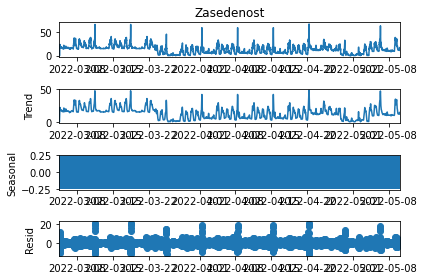

In [61]:
# result = seasonal_decompose(first_parking["Zasedenost"], model='additive', period=52)
# result.plot()
# plt.show()

result = seasonal_decompose(first_parking["Zasedenost"], model='additive', period=12,extrapolate_trend="freq")
result.plot()
plt.show()


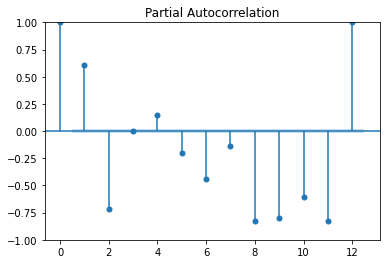

In [64]:
plot_pacf(result.seasonal, lags =12)
plt.show()

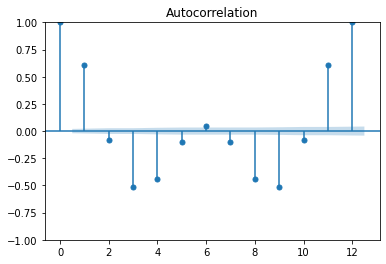

In [66]:
plot_acf(result.seasonal, lags=12)
plt.show()


In [11]:
def cointegration_test(df):
    res = coint_johansen(df, -1, 5)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]

    def adjust(val, length=6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace, 2), 9), ">", adjust(cvt, 8), ' =>  ', trace > cvt)


In [12]:
# pq = []
# for name, column in train[["Zasedenost"]].iteritems():
#     print(f'Searching order of p and q for : {name}')
#     stepwise_model = auto_arima(train[name], start_p=1, start_q=1, max_p=7, max_q=7, seasonal=False,
#                                 trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, maxiter=1000)
#     parameter = stepwise_model.get_params().get('order')
#     print(f'optimal order for:{name} is: {parameter} \n\n')
#     pq.append(stepwise_model.get_params().get('order'))


In [13]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res


In [15]:
# # Find the optimal seasonal order parameters
# df_results_moni = pd.DataFrame(columns=['p', 'q', 'RMSE Zasedenost'])
# print('Grid Search Started')
# start = timer()
# for i in pq:
#     if i[0] == 0 and i[2] == 0:
#         pass
#     else:
#         print(f' Running for {i}')
#         model = SARIMAX(endog=y, exog=exog_train, order=(i[0], i[1], i[2]), seasonal_order=(1, 1, 1, 52)).fit()
#         y_pred = model.get_forecast(len(test.index))
#         y_pred_df = y_pred.conf_int(alpha=0.05)
#         y_pred_df["Predictions"] = model.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
#         y_pred_df.index = test.index
#         sarima_rmse = np.sqrt(mean_squared_error(test["Zasedenost"].values, y_pred_df["Predictions"]))
#         print("SARIMA RMSE: ", sarima_rmse)
#         df_results_moni = df_results_moni.append(
#             {'p': i[0], 'd': i[1], 'q': i[2], 'RMSE Zasedenost': sarima_rmse, }, ignore_index=True)
# end = timer()
# print(f' Total time taken to complete grid search in seconds: {(end - start)}')


In [16]:
# # Print the optimal seasonal order parameters
# df_results_moni.sort_values(by=['RMSE Zasedenost'])


In [70]:
# Create the model
# endog = y.rolling(window="4h", center=False).mean() ?
SARIMAXmodel = SARIMAX(endog=y, exog=exog_train, order=(6, 1, 7), seasonal_order=(1, 1, 1, 12)).fit()

y_pred = SARIMAXmodel.predict(start=test.index[0], end=test.index[-1], exog=exog_test)
y_pred_df = pd.DataFrame()
y_pred_df["Predictions"] = pd.Series(y_pred)
y_pred_df.index = test.index

sarima_rmse = np.sqrt(mean_squared_error(test["Zasedenost"].values, y_pred_df["Predictions"]))
print("SARIMA RMSE: ", sarima_rmse)

# print(SARIMAXmodel.summary())


SARIMA RMSE:  8.815424982397923


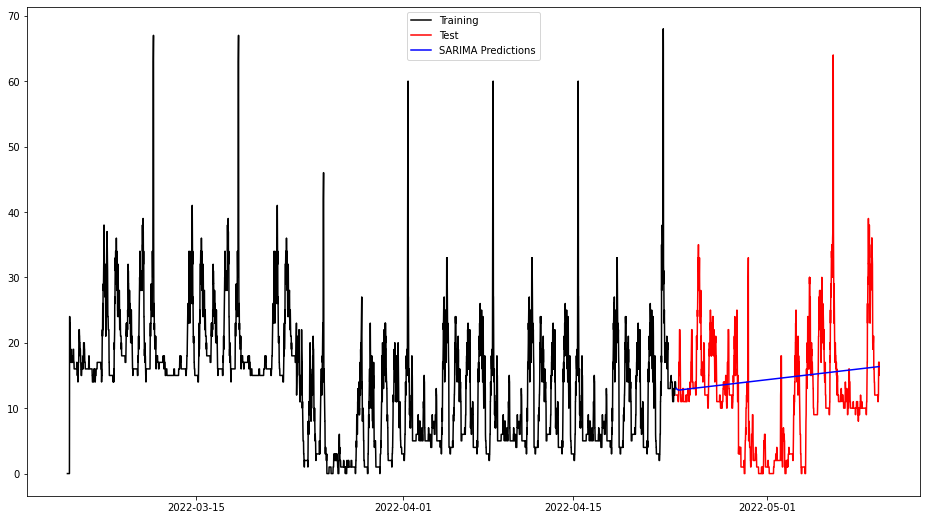

In [72]:
plt.figure(figsize=(16, 9))
plt.plot(train["Zasedenost"], color="black", label='Training')
plt.plot(test["Zasedenost"], color="red", label='Test')
plt.plot(y_pred_df["Predictions"], color='Blue', label='SARIMA Predictions')
plt.legend()
plt.show()
